__This file contains codes observing properties of data__

In [1]:
# Load libraries for analysis and visualization
import pandas as pd # collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import numpy as np  # foundational package for scientific computing
import re           # Regular expression operations
import matplotlib.pyplot as plt # Collection of functions for scientific and publication-ready visualization
import lightgbm as lgb
%matplotlib inline

import plotly.offline as py     # Open source library for composing, editing, and sharing interactive data visualization 
from matplotlib import pyplot
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter

# Machine learning libraries
import sys
sys.path.append('/Users/minjielu/anaconda3/envs/python/lib/python3.5/site-packages')

import xgboost as xgb  # Implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning
import seaborn as sns  # Visualization library based on matplotlib, provides interface for drawing attractive statistical graphics

import sklearn         # Collection of machine learning algorithms
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, precision_recall_curve, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

### 1. Try to predict generosity or meanness of customers instead of values of transactions 

It can be observed that target values of some customers are high percentiles in the distribution of features of these customers while others are low percentiles. So it might be better to build a model to predict this percentile first and then predict the transaction value with the distribution of features.

In [2]:
train = pd.read_csv('../train.csv')
#test = pd.read_csv('./test.csv')

In [4]:
# Caculate percentile of target values in the distribution of features of customers in train set. Zeros are removed
from scipy import stats
train['target_percentile'] = 0.0
for ind, row in train.iterrows():
    train.loc[ind,train.columns == 'target_percentile'] = stats.percentileofscore(np.log1p(row[2:][row != 0].unique()[2:].astype(float)),np.log1p(row['target'])) 

In [5]:
train_y = train['target_percentile']
train_x = train.copy()
# There are some columns that have obvious negative correlations to target. Some observations show if a customer has too many
# nonzero values in these columns, the customer tends to be mean no matter how large these values are.
# So nonzero values are simply replaced by 1
# for column in train_x.columns:
    # train_x.loc[train_x[column] != 0,column] = 1

In [6]:
# Column '913970e60' is one of the columns that have obvious negative correlations to target
# So rows having nonzero '913970e60' are listed below
# Percentiles are not necessary small
train.loc[train['913970e60'] != 0,'target_percentile']

338     91.666667
579     50.000000
611     69.230769
683     58.620690
788     44.444444
831     91.891892
1314    27.272727
2003    44.186047
2040    62.068966
2410    10.810811
2668    75.000000
2790     4.230769
2865    11.764706
3918    84.210526
4065    83.333333
4150    74.509804
4378    60.465116
Name: target_percentile, dtype: float64

In [15]:
# This cell is used to observe properties of certain row that I am interested in
pd.set_option('display.max_columns',5000)
sample = train[train['target'] == 10000000.00].iloc[13].T # pick out a specific row within rows having a specific target value
sample = sample.to_frame()
sample.columns = ['value']

print(sum(sample['value'] != 0)) # Number of nonzero values in this row
print(sample['value'].unique()[2:].astype(float)) # Unique values in this row
print(np.percentile(np.log1p(sample['value'].unique()[2:].astype(float)),25)) # 25% percentile of log features
print(np.percentile(np.log1p(sample['value'].unique()[2:].astype(float)),50)) # 50% percentile
print(np.percentile(np.log1p(sample['value'].unique()[2:].astype(float)),75)) # 75% percentiel
print(np.log1p(10000000.00)) # log target

sample = sample.drop(['ID','target'])
sample = pd.concat([sample,nonzero_corr],axis=1)

sample[sample['value'] != 0] # show correlations of each column where this row has nonzero value to target

75
[0.00000000e+00 1.32000000e+07 6.80000000e+07 1.90000000e+07
 2.00000000e+07 2.50000000e+07 2.72000000e+08 2.40000000e+08
 2.00000000e+08 5.00000000e+07 1.60000000e+07 9.00000000e+07
 1.08000000e+08 5.00000000e+06 1.66666667e+01 3.86082194e+07]
16.540006372856585
17.25168109924506
18.360900628141177
16.118095750958314


value  correlation_to_target  nonzero_cnt
963a49cdc             1.32e+07               0.424268         1471
4e86dd8f3              6.8e+07              -0.008064          326
68a945b18             1.32e+07               0.472264          849
90b0ed912              1.9e+07               0.173780          102
935ca66a9             1.32e+07               0.468111          893
4fc9da4e3                2e+07              -0.110815           11
861076e21             1.32e+07               0.432921          920
d7285f250              2.5e+07               0.064456          208
26fc93eb7             1.32e+07               0.469027         1492
0572565c2             1.32e+07               0.379296         1547
66ace2992             1.32e+07               0.411950         1521
fb49e4212             1.32e+07               0.459505         1482
6619d81fc             1.32e+07               0.355052         1533
8d4d84ddc             2.72e+08               0.141147          189
fc99f9426             1.32e+07               0.448439         1518
bd6da0cca             1.32e+07               0.473125          871
1db387535             1.32e+07               0.385282         1525
ea772e115             1.32e+07               0.541224          824
ad009c8b9             1.32e+07               0.555233          842
51d4053c7             1.32e+07               0.400950          781
2ec5b290f             1.32e+07               0.369517         1477
44d5b820f             1.32e+07               0.516704          791
0ff32eb98             1.32e+07               0.361124         1565
166008929             1.32e+07               0.417212          927
b7c931383             1.32e+07               0.365005          796
241f0f867             1.32e+07               0.377511         1461
cbb673163             1.32e+07               0.480560          868
1931ccfdd             1.32e+07               0.365666         1509
f02ecb19c             1.32e+07               0.450584          920
1fe5d56b9             1.32e+07               0.510235          809
b261b0abe            240000000               0.129033          106
d26279f1a                2e+08               0.151674          593
c612c5f8f             50000000               0.163775          159
834fb292d             68000000               0.066720           95
ff65215db              2.4e+08               0.159867          622
58ed8fb53             2.72e+08               0.180828          597
7db1be063                2e+08               0.156518          312
91f701ba2             1.32e+07               0.370076         1560
8c922fa9a                2e+08               0.145177           98
ca2b906e8             1.32e+07               0.459949          901
703885424             1.32e+07               0.383537         1513
f97d9431e             1.32e+07               0.458515          903
62fb56487             1.32e+07               0.541252          842
324921c7b             1.32e+07               0.417909         1504
c0d2348b7             1.32e+07               0.477172          883
491b9ee45             1.32e+07               0.388403         1523
c8d582dd2             1.32e+07               0.523263          886
175891ff4              1.6e+07              -0.134613           15
c10f31664             1.32e+07               0.526799          849
4bcf15776             1.32e+07               0.512704          812
70feb1494             1.32e+07               0.456874         1532
adb64ff71             1.32e+07               0.371921         1547
11e12dbe8             1.32e+07               0.470562          928
9de83dc23             1.32e+07               0.415369          902
62e59a501             1.32e+07               0.382749         1477
5c6487af1             1.32e+07               0.380030         1539
f1b6cc03f                9e+07               0.098868          186
bb0ce54e9             1.32e+07               0.470090          889
f74e8f13d             1.32e+07               0.509410         1494
4ead8

In [10]:
# Calculate average value of each row
train['ave'] = (train.loc[:,(train.columns != 'ID') & (train.columns != 'traget') & (train.columns != 'ave')].sum(axis=1))/((train.loc[:,(train.columns != 'ID') & (train.columns != 'traget') & (train.columns != 'ave')] != 0).sum(axis=1))
# correlations = train.corr() # Correlation matrix of train data. Zeros are not removed

In [11]:
# correlations = correlations.loc[correlations.index == 'target',:].sort_values(['target'],axis=1,ascending=False)

In [12]:
train['ave']
#pd.set_option('display.max_columns',2000)
#correlations

0       7.295850e+06
1       7.831863e+06
2       4.310005e+06
3       1.474614e+06
4       6.896218e+06
5       7.019558e+06
6       6.535111e+06
7       2.357475e+07
8       1.042622e+06
9       1.325800e+06
10      5.468161e+07
11      2.326659e+06
12      8.329479e+05
13      1.357670e+07
14      8.064000e+05
15      4.860344e+06
16      8.514782e+05
17      5.272993e+06
18      6.201007e+06
19      3.232127e+06
20      6.663027e+06
21      6.643409e+06
22      5.867426e+06
23      1.368380e+07
24      1.319275e+06
25      7.644673e+05
26      8.899049e+06
27      6.412424e+06
28      6.104909e+06
29      7.060919e+06
            ...     
4429    2.689779e+06
4430    2.000530e+07
4431    4.164043e+06
4432    1.869232e+07
4433    7.202860e+06
4434    8.302091e+05
4435    1.449557e+07
4436    5.339094e+06
4437    4.824244e+06
4438    9.727899e+06
4439    5.262251e+06
4440    5.949822e+06
4441    3.747369e+06
4442    1.341815e+07
4443    5.520478e+06
4444    1.887853e+06
4445    5.215

### 2. Calculate correlation of each column to target

A more general method to tell feature importants is to utilize the feature importants returned by tree-based method. Another way is to sort cross validation score produced when each feature is used solely.

In [13]:
# Calculate correlations of each column to target. Zeros are removed
nonzero_corr = []
for column in train.columns:
    if column != 'ID' and column != 'target':
        train_1 = train[train[column] != 0][['target',column]]
        corr_tmp = train_1.corr()
        nonzero_corr.append([corr_tmp.loc['target',column],train_1.shape[0]])
        
column_label = list(train.columns)
column_label.pop(0) # Remove column 'ID'
column_label.pop(0) # Remove column 'target

nonzero_corr = pd.DataFrame(nonzero_corr,columns=['correlation_to_target','nonzero_cnt'],index=column_label)
#nonzero_corr = nonzero_corr.sort_values(['target'])
#nonzero_corr[(nonzero_corr['target'] < 0.4) & (nonzero_corr['target'] > -0.01)].shape[0]
#nonzero_corr.shape[0]
#nonzero_corr

In [16]:
nonzero_corr

correlation_to_target  nonzero_cnt
48df886f9                       0.828976           39
0deb4b6a8                      -0.266614            4
34b15f335                       0.161902           33
a8cb14b00                       1.000000            2
2f0771a37                       0.854765            5
30347e683                      -0.044161           47
d08d1fbe3                       0.328351            5
6ee66e115                      -0.183215            5
20aa07010                       0.391260         1494
dc5a8f1d8                       0.279785          123
11d86fa6a                       0.127497          165
77c9823f2                            NaN            1
8d6c2a0b2                       0.948722            6
4681de4fd                       0.375900          519
adf119b9a                       0.679541          160
cff75dd09                       0.395286           35
96f83a237                       0.100675           25
b8a716ebf                       0.221538          334
6c7a4567c                       0.462353           28
4fcfd2b4d                      -0.040860           27
f3b9c0b95                       0.084186           39
71cebf11c                      -0.098613           21
d966ac62c                       0.816984           79
68b647452                       0.287278          131
c88d108c9                      -0.570858           11
ff7b471cd                       0.585383            4
d5308d8bc                            NaN            0
0d866c3d7                       0.231933          256
bc3f77679                       0.023239           39
bd8f989f1                       0.154903          560
0eff5bf95                      -0.010447           10
22ed6dba3                       0.289668          745
92b13ebba                       0.044437          315
c330f1a67                            NaN            0
233c7c17c                       0.053982          217
2cb4d123e                       0.209332          146
eeac16933                            NaN            0
87ffda550                       0.376219          754
822e49b95                       0.428536          712
316b978cd                       0.612731          120
d04e16aed                       0.122712          299
5d5c5ce6d                      -0.028276           34
ec863cb52                       0.053451           42
11ad148bd                      -0.108748          126
ea18d720e                       0.624511          109
408d86ce9                       0.098548          168
69d8b4020                       0.030202           15
b0868a049                       0.294105           69
80b14398e                       0.146670          325
ecdef52b2                       0.058895          117
c36bcacc5                       1.000000            2
151d318cd                       0.636691           40
ab0cddb90                       0.292597           10
2d6bd8275                       0.391144          205
dfdf4b580                       0.094996          149
c87722678                       0.175551            5
a8c320153                       0.044129           44
7df8788e8                            NaN            0
a04684f1f                      -0.024483           35
fa977f17b                       0.517005           34
feed9d437                      -0.058573          249
645b47cde                       0.309847          167
7298ca1ef                      -0.008559          147
d80abf8bc                       0.557275           33
654dd8a3b                       0.165627          294
7fc39583c                      -0.143697           19
8c94b6675                       0.067030          355
e421c414e                       0.100756           38
5b91580ee                            NaN            0
964335fdf                       0.275015            6
5a86cabd0                      -0.005503           26
6cb207ac9                       0.184665           17
c1bc828da                      -0.764758            3
e90ed19da              

In [14]:
# Column '6b119d8ce' is one of columns that have obvious negative correlations to target
pd.set_option('display.max_rows',3000)
train.loc[train['6b119d8ce'] != 0,['6b119d8ce','target','target_percentile']]

6b119d8ce       target  target_percentile
8        16000.00    979000.00          56.250000
13      600000.00   7000000.00          50.568182
21      760000.00   3266666.66          78.282828
22     1298000.00   6140000.00          83.613445
73      530000.00   4000000.00          64.516129
74    25000000.00  32500000.00          34.782609
81       16000.00   3925333.34          55.555556
95    40000000.00  30000000.00          22.222222
114     600000.00   3095200.00          57.424442
126    1400000.00  20000000.00         100.000000
127      40000.00  10814666.66          75.035663
143   40000000.00  32000000.00          22.857143
151     598857.14    200000.00          14.285714
171     400000.00   5000000.00          71.794872
181    2500000.00   1400000.00          34.210526
197     500000.00   1900000.00          76.470588
211     120000.00    300000.00          11.764706
214     816000.00   5187333.34          66.844208
230   30000000.00  30000000.00          23.913043
231    2078000.00   1192000.00          32.460733
235    1400000.00    406000.00          26.615385
245    1470000.00   1477600.00          52.136752
251    3407000.00   1610000.00          29.464286
284     354000.00  10200000.00          77.777778
298    2000000.00   4000000.00          77.777778
302     500000.00   2000000.00          80.000000
303     354000.00  10000000.00          75.000000
314    3304000.00   1809333.34          52.857143
334    2518000.00   3034400.00          39.015152
359    8720000.00    980000.00          34.513274
362    2200000.00   2060000.00          62.758621
369     637000.00  10849666.66          92.139738
375    4067000.00  16991333.34          91.489362
378    1470000.00   2352551.72          60.681818
380     354000.00    350000.00          16.393443
391    3559333.34   3938750.00          68.619247
404    3740000.00   3342666.66          60.434783
412       2000.00   4234800.00          65.217391
418    1700000.00    370000.00          23.687943
424     500000.00   1000000.00          13.526570
426   30000000.00  30000000.00          23.404255
445    1890000.00   1258800.00          34.558824
461   20000000.00  25000000.00          21.875000
462   30000000.00  38571428.58          48.979592
475     354000.00   3320000.00          60.465116
481     300000.00   1500000.00          57.894737
510   20000000.00  22000000.00          17.647059
511    1470000.00    296444.44          20.588235
517    1439000.00   1190000.00          35.555556
526     700000.00     58000.00          29.411765
532   32500000.00  33333333.34          28.125000
540     500000.00   2500000.00          86.363636
562   20000000.00  20000000.00          17.142857
603    4096000.00   3743666.66          64.285714
611     120000.00   1500000.00          69.230769
625    1470000.00    550000.00          30.508475
626    3310000.00  11115200.00          77.205882
650      60000.00    380000.00          24.383917
655    2000000.00   2050000.00          42.857143
665   10440000.00   8000000.00          47.368421
673     598857.14  10400000.00          96.052632
680     598857.14    416666.66          44.117647
681     100000.00   1310000.00          54.347826
720   20000000.00  38000000.00          52.380952
722   20000000.00  18500000.00           8.823529
748    2000000.00   5300000.00         100.000000
771     400000.00   1333333.34          61.538462
777      79000.00  10000000.00          86.111111
788     120000.00   1000000.00          44.444444
791    4000000.00   1392666.66          31.535270
806    1134000.00  18383714.28          97.071130
814    1400000.00   2900000.00          72.413793
816    1470000.00   1586888.88          54.242424
831     120000.00   6000000.00          91.891892
842    1800000.00    200000.00           1.895735
853    1530000.00   3200000.00          72.093023
856    2194000.00    530000.00          16.942149
862    2000000.00   9260000.00          60.317460
881      10000.00     74000.00          17.567568
891    1

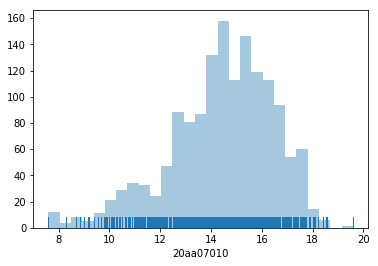

In [15]:
# This cell generates barplot of distribution of a chosen column
column = '6b119d8ce'
sns.distplot(np.log1p(train.loc[train[column] != 0,column]),kde=False,rug=True)

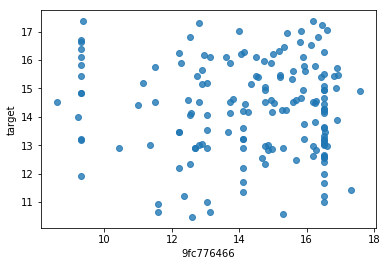

In [3]:
# This cell generates stripplot of target versus values of a chosen column
column = '9fc776466'
sns.regplot(x=np.log1p(train.loc[train[column] != 0,column]),y=np.log1p(train.loc[train[column] != 0,'target']),fit_reg=False)
#plt.xticks(np.arange(min(np.log1p(train.loc[train['9fc776466'] != 0,'adf119b9a'])), max(np.log1p(train.loc[train['adf119b9a'] != 0,'adf119b9a']))+1, 1.0))

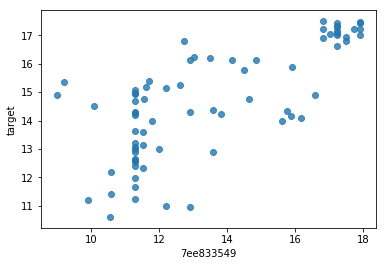

In [4]:
# This cell generates stripplot of target versus values of a chosen column
# Column '7ee833549' is a column with high correlation to target and having reasonable numbers of nonzero values
column = '7ee833549'
sns.regplot(x=np.log1p(train.loc[train[column] != 0,column]),y=np.log1p(train.loc[train[column] != 0,'target']),fit_reg=False)
#plt.xticks(np.arange(min(np.log1p(train.loc[train['9fc776466'] != 0,'adf119b9a'])), max(np.log1p(train.loc[train['adf119b9a'] != 0,'adf119b9a']))+1, 1.0))

Like the plot above, most columns with large correlations to target show a decreasing standard deviation for higher values which means higher values are more determinant. Other columns also have value ranges that are more determinant. This observation results in the method in 'Clean_data-delete_ranges_with_large_std.ipynb' which cleans data by only keeping ranges of values with small standard deviation.

### 3. Column selection

Columns are abandoned according to their correlations to target and sparsity.

In [112]:
# train_y = train['target']
# train_x = train.loc[:,(train.columns !='ID') & (train.columns != 'target')].loc[:,((nonzero_corr['target'] > 0) | (nonzero_corr['target'] < 0)) & (nonzero_corr['nonzero_cnt'] > 200)]
# test_x = test.loc[:,(test.columns != 'ID') & (test.columns != 'target')].loc[:,((nonzero_corr['target'] > 0) | (nonzero_corr['target'] < 0)) & (nonzero_corr['nonzero_cnt'] > 200)]
# train_x = train.loc[:,((nonzero_corr['target'] > 0) | (nonzero_corr['target'] > )) & (nonzero_corr['nonzero_cnt'] > 200)]

train_x = train.loc[:,(train.columns != 'ID') & (train.columns != 'target') & (train.columns != 'target_percentile')].loc[:,(((nonzero_corr['correlation_to_target'] < -0.05) | (nonzero_corr['correlation_to_target'] > 0.2)) & (nonzero_corr['nonzero_cnt'] > 200))]
train_x['target'] = train['target'] # Use this line if wants to predict transaction values
train_x['ID'] = train['ID']
# train_y = train['target_percentile'] # Use this line if wants to predict percentiles
# train_y = train_y.fillna(50)
# train_y

In [37]:
#train_1 = train[train['2f0771a37'] != 0][['target','2f0771a37']]
#train_1[['target','2f0771a37']].corr()

In [65]:
from sklearn.metrics import mean_squared_error
def fit_predict(data, y, test):
    # Create folds
    folds = KFold(n_splits=5, shuffle=True, random_state=1)
    # Init predictions
    sub_preds = np.zeros(test.shape[0])
    oof_preds = np.zeros(data.shape[0])
    # Convert to lightgbm Dataset
    dtrain = lgb.Dataset(data=data, label=y, free_raw_data=False)
    # Construct dataset so that we can use slice()
    dtrain.construct()
    lgb_params = {
        'objective': 'regression',
        'num_leaves': 58,
        'subsample': 0.6143,
        'colsample_bytree': 0.6453,
        'min_split_gain': np.power(10, -2.5988),
        'reg_alpha': np.power(10, -2.2887),
        'reg_lambda': np.power(10, 1.7570),
        'min_child_weight': np.power(10, -0.1477),
        'verbose': -1,
        'seed': 3,
        'boosting_type': 'gbdt',
        'max_depth': -1,
        'learning_rate': 0.05,
        'metric': 'l2',
    }
    # Run KFold
    for trn_idx, val_idx in folds.split(data):
        # Train lightgbm
        clf = lgb.train(
            params=lgb_params,
            train_set=dtrain.subset(trn_idx),
            valid_sets=dtrain.subset(val_idx),
            num_boost_round=10000, 
            early_stopping_rounds=100,
            verbose_eval=50
        )
        # Predict Out Of Fold and Test targets
        # Using lgb.train, predict will automatically select the best round for prediction
        oof_preds[val_idx] = clf.predict(dtrain.data.iloc[val_idx])
        #sub_preds += clf.predict(test.loc[:,(test.columns != 'ID')]) / folds.n_splits
        print(sub_preds)
        # Display current fold score
        print(mean_squared_error(np.log1p(y.iloc[val_idx]), 
                                 oof_preds[val_idx]) ** .5)
    # Display Full OOF score (square root of a sum is not the sum of square roots)
    print('Full Out-Of-Fold score : %9.6f' 
          % (mean_squared_error(np.log1p(y), oof_preds) ** .5))

    return oof_preds, sub_preds

In [70]:
#test_1 = test.loc[:,(test.columns != 'ID')]
[oof_preds, subpreds] = fit_predict(train_x_1,train_y,test)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 806.167
[100]	valid_0's l2: 801.616
[150]	valid_0's l2: 806.461
[200]	valid_0's l2: 811.218
Early stopping, best iteration is:
[105]	valid_0's l2: 800.858
[0. 0. 0. ... 0. 0. 0.]
46.28256798316216
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 734.592
[100]	valid_0's l2: 731.028
[150]	valid_0's l2: 734.928
Early stopping, best iteration is:
[71]	valid_0's l2: 728.698
[0. 0. 0. ... 0. 0. 0.]
46.00375593414769
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 713.29
[100]	valid_0's l2: 711.048
[150]	valid_0's l2: 715.663
Early stopping, best iteration is:
[82]	valid_0's l2: 708.811
[0. 0. 0. ... 0. 0. 0.]
46.78134176496071
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 722.979
[100]	valid_0's l2: 714.831
[150]	valid_0's l2: 716.856
[200]	valid_0's l2: 716.267
Early stopping, best iteration is:
[103]	valid_0

In [ ]:
'''
subpreds[subpreds < 9] = 11.0 # Don't allow log target to be smaller than 11
subpreds = np.expm1(subpreds)
pd.set_option('display.max_rows',3000)
from sklearn.metrics import mean_squared_error
print('Full Out-Of-Fold score : %9.6f' 
      % (mean_squared_error(np.log1p(train['target']), oofpreds) ** .5))
oofpreds = pd.Series(oofpreds,name='preds')
tmp = pd.concat([np.log1p(train['target']),oofpreds],axis=1)
tmp['difference'] = (tmp['target']-tmp['preds'])**2
# tmp is used to observe error between predictions and true targets of each row. Improvement of model may be learnt from rows of large errors
tmp
'''

In [ ]:
'''
# Differences between predicted percentiles and true percentiles
train['target_percentile_preds'] = oof_preds
train[['target_percentile','target_percentile_preds']]
'''

In [ ]:
'''
# Calculate transcation values for test set if percentiles are predicted
subpreds[subpreds < 10] = 10 # Don't allow percentiles to be lower than 10%
subpreds[subpreds > 90] = 90 # Don't allow percentiles to be higher than 90%
for ind, row in test.iterrows():
    subpreds[ind] = np.percentile(np.log1p(row.unique()[1:].astype(float)),subpreds[ind])
'''

In [98]:
# Generate submission file
customerid = test['ID']
#result = pd.Series(gbm.predict(test_x),name='target')
result = pd.Series(np.expm1(subpreds),name='target')
result = pd.concat([customerid,result],axis=1)

In [99]:
#min_value = train_y.min()
#result.loc[result['target'] < min_value,'target'] = min_value
result.to_csv('Santander_result.csv',index=False)